<a href="https://colab.research.google.com/github/RaviSharma1901/Cognifyz-ML-Tasks/blob/main/restaurant-cuisine-classification/restaurant_cuisine_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🍽️ Restaurant Cuisine Classification using Multi-Label Random Forest

- __Cognifyz Task 3 – Restaurant Cuisine Classification__

    - This notebook presents a complete workflow for predicting restaurant cuisines using a multi-label classification approach. Techniques include data cleaning, label encoding, outlier handling, and performance evaluation using ensemble modeling. A deployment-ready model is saved for future integration.


**Author**: [Ravi Sharma]  
**GitHub**: https://github.com/RaviSharma1901/Cognifyz-ML-Tasks

__Import the important Library__

In [ ]:
# importing necessary libraries
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

from sklearn.metrics import classification_report, hamming_loss, accuracy_score


__Load the Data__

In [ ]:
# Load the dataset from a CSV file
df_classification= pd.read_csv('Dataset.csv',)
df_classification.head()

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,...,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",...,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,...,Botswana Pula(P),Yes,No,No,No,3,4.5,Dark Green,Excellent,591
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...","Edsa Shangri-La, Ortigas, Mandaluyong City","Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",...,Botswana Pula(P),Yes,No,No,No,4,4.4,Green,Very Good,270
3,6318506,Ooma,162,Mandaluyong City,"Third Floor, Mega Fashion Hall, SM Megamall, O...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.056475,14.585318,"Japanese, Sushi",...,Botswana Pula(P),No,No,No,No,4,4.9,Dark Green,Excellent,365
4,6314302,Sambo Kojin,162,Mandaluyong City,"Third Floor, Mega Atrium, SM Megamall, Ortigas...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.057508,14.584450,"Japanese, Korean",...,Botswana Pula(P),Yes,No,No,No,4,4.8,Dark Green,Excellent,229


__Check the Shape__

In [ ]:
df_classification.shape

(9551, 21)

__Dataset Overview__

- This dataset contains metadata for 9,551 restaurants, including location, service attributes, and user ratings. The task is to predict cuisines offered by each restaurant using structured features.

    - __Key Columns__


| Feature                 | Description                                                |
|------------------------|------------------------------------------------------------|
| `City`                 | Encoded restaurant location                                |
| `Currency`             | Encoded price currency                                     |
| `Has Table booking`    | Binary indicator (`Yes` → 1, `No` → 0)                     |
| `Has Online delivery`  | Binary indicator                                           |
| `Average Cost for two` | Price-based feature, capped to reduce outliers            |
| `Price range`          | Discrete pricing level                                     |
| `Aggregate rating`     | Float rating value (restaurant rating out of 5)           |
| `Votes`                | Number of user votes cast                                 |
| `Cuisines`             | Multi-label target, transformed using `MultiLabelBinarizer` |


In [ ]:
# non-null counts, and memory usage
df_classification.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9551 entries, 0 to 9550
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Restaurant ID         9551 non-null   int64  
 1   Restaurant Name       9551 non-null   object 
 2   Country Code          9551 non-null   int64  
 3   City                  9551 non-null   object 
 4   Address               9551 non-null   object 
 5   Locality              9551 non-null   object 
 6   Locality Verbose      9551 non-null   object 
 7   Longitude             9551 non-null   float64
 8   Latitude              9551 non-null   float64
 9   Cuisines              9542 non-null   object 
 10  Average Cost for two  9551 non-null   int64  
 11  Currency              9551 non-null   object 
 12  Has Table booking     9551 non-null   object 
 13  Has Online delivery   9551 non-null   object 
 14  Is delivering now     9551 non-null   object 
 15  Switch to order menu 

__Check for Null Value__

In [ ]:
df_classification.isnull().sum()

Restaurant ID           0
Restaurant Name         0
Country Code            0
City                    0
Address                 0
Locality                0
Locality Verbose        0
Longitude               0
Latitude                0
Cuisines                9
Average Cost for two    0
Currency                0
Has Table booking       0
Has Online delivery     0
Is delivering now       0
Switch to order menu    0
Price range             0
Aggregate rating        0
Rating color            0
Rating text             0
Votes                   0
dtype: int64

#### __Cleaning and Data Preprocessing__

- __Handle Missing value__

In [ ]:
# Fill missing values in 'Cuisines' column with the mode of the column
df_classification['Cuisines'] = df_classification['Cuisines'].fillna(df_classification['Cuisines'].mode()[0])

In [ ]:
df_classification.isnull().sum()

Restaurant ID           0
Restaurant Name         0
Country Code            0
City                    0
Address                 0
Locality                0
Locality Verbose        0
Longitude               0
Latitude                0
Cuisines                0
Average Cost for two    0
Currency                0
Has Table booking       0
Has Online delivery     0
Is delivering now       0
Switch to order menu    0
Price range             0
Aggregate rating        0
Rating color            0
Rating text             0
Votes                   0
dtype: int64

- __Check columns__

In [ ]:
df_classification.columns

Index(['Restaurant ID', 'Restaurant Name', 'Country Code', 'City', 'Address',
       'Locality', 'Locality Verbose', 'Longitude', 'Latitude', 'Cuisines',
       'Average Cost for two', 'Currency', 'Has Table booking',
       'Has Online delivery', 'Is delivering now', 'Switch to order menu',
       'Price range', 'Aggregate rating', 'Rating color', 'Rating text',
       'Votes'],
      dtype='object')

- __Drop irrelevant columns__

In [ ]:
remove_cols = ['Restaurant ID', 'Restaurant Name','Country Code', 'Address', 'Locality', 'Locality Verbose',
               'Longitude', 'Latitude',  'Switch to order menu', 'Rating text', 'Rating color']
df_classification = df_classification.drop(columns=remove_cols)


In [ ]:
df_classification

,City,Cuisines,Average Cost for two,Currency,Has Table booking,Has Online delivery,Is delivering now,Price range,Aggregate rating,Votes
0,Makati City,"French, Japanese, Desserts",1100,Botswana Pula(P),Yes,No,No,3,4.8,314
1,Makati City,Japanese,1200,Botswana Pula(P),Yes,No,No,3,4.5,591
2,Mandaluyong City,"Seafood, Asian, Filipino, Indian",4000,Botswana Pula(P),Yes,No,No,4,4.4,270
3,Mandaluyong City,"Japanese, Sushi",1500,Botswana Pula(P),No,No,No,4,4.9,365
4,Mandaluyong City,"Japanese, Korean",1500,Botswana Pula(P),Yes,No,No,4,4.8,229
...,...,...,...,...,...,...,...,...,...,...
9546,��stanbul,Turkish,80,Turkish Lira(TL),No,No,No,3,4.1,788
9547,��stanbul,"World Cuisine, Patisserie, Cafe",105,Turkish Lira(TL),No,No,No,3,4.2,1034
9548,��stanbul,"Italian, World Cuisine",170,Turkish Lira(TL),No,No,No,4,3.7,661
9549,��stanbul,Restaurant Cafe,120,Turkish Lira(TL),No,No,No,4,4.0,901


-  __Removing Unwanted Characters__

In [ ]:
df_classification[['City', 'Cuisines', 'Currency']] = df_classification[['City', 'Cuisines', 'Currency']].apply(
    lambda col: col.str.replace('[�_]', '', regex=True))

In [ ]:
df_classification[['City', 'Cuisines', 'Currency']]

,City,Cuisines,Currency
0,Makati City,"French, Japanese, Desserts",Botswana Pula(P)
1,Makati City,Japanese,Botswana Pula(P)
2,Mandaluyong City,"Seafood, Asian, Filipino, Indian",Botswana Pula(P)
3,Mandaluyong City,"Japanese, Sushi",Botswana Pula(P)
4,Mandaluyong City,"Japanese, Korean",Botswana Pula(P)
...,...,...,...
9546,stanbul,Turkish,Turkish Lira(TL)
9547,stanbul,"World Cuisine, Patisserie, Cafe",Turkish Lira(TL)
9548,stanbul,"Italian, World Cuisine",Turkish Lira(TL)
9549,stanbul,Restaurant Cafe,Turkish Lira(TL)


### __Encode Categorical Variables__

In [ ]:
df_classification.columns

Index(['City', 'Cuisines', 'Average Cost for two', 'Currency',
       'Has Table booking', 'Has Online delivery', 'Is delivering now',
       'Price range', 'Aggregate rating', 'Votes'],
      dtype='object')

In [ ]:
df_encode = df_classification.copy()

- __Map Binary Column__

In [ ]:
col_binary = ['Has Table booking', 'Has Online delivery', 'Is delivering now']
for col in col_binary:
    df_encode[col] = df_encode[col].map({'Yes':1,'No':0})

- __Label encode for City and Currency__

In [ ]:
for col in ['City','Currency']:
    df_encode[col] = LabelEncoder().fit_transform(df_encode[col])

In [ ]:
df_encode

,City,Cuisines,Average Cost for two,Currency,Has Table booking,Has Online delivery,Is delivering now,Price range,Aggregate rating,Votes
0,73,"French, Japanese, Desserts",1100,0,1,0,0,3,4.8,314
1,73,Japanese,1200,0,1,0,0,3,4.5,591
2,75,"Seafood, Asian, Filipino, Indian",4000,0,1,0,0,4,4.4,270
3,75,"Japanese, Sushi",1500,0,0,0,0,4,4.9,365
4,75,"Japanese, Korean",1500,0,1,0,0,4,4.8,229
...,...,...,...,...,...,...,...,...,...,...
9546,140,Turkish,80,11,0,0,0,3,4.1,788
9547,140,"World Cuisine, Patisserie, Cafe",105,11,0,0,0,3,4.2,1034
9548,140,"Italian, World Cuisine",170,11,0,0,0,4,3.7,661
9549,140,Restaurant Cafe,120,11,0,0,0,4,4.0,901


### __Multi-label Target(Cuisines)__

In [ ]:
df_cuisines = df_encode.copy()

In [ ]:
df_cuisines['Cuisines'] = df_cuisines['Cuisines'].apply(lambda x: [i.strip() for i in str(x).split(',')])

In [ ]:
df_cuisines['Cuisines']

0             [French, Japanese, Desserts]
1                               [Japanese]
2       [Seafood, Asian, Filipino, Indian]
3                        [Japanese, Sushi]
4                       [Japanese, Korean]
                       ...                
9546                             [Turkish]
9547     [World Cuisine, Patisserie, Cafe]
9548              [Italian, World Cuisine]
9549                     [Restaurant Cafe]
9550                                [Cafe]
Name: Cuisines, Length: 9551, dtype: object

In [ ]:
multi_label = MultiLabelBinarizer()

# The binary NumPy array
target = multi_label.fit_transform(df_cuisines['Cuisines'])
# Create a DataFrame with appropriate column names
target_df = pd.DataFrame(target, columns=multi_label.classes_, index=df_cuisines.index)

# Drop the original 'Cuisines' column and concatenate the new binary columns
df_cuisines = pd.concat([df_cuisines.drop(columns=['Cuisines']), target_df], axis=1)

In [ ]:
df_cuisines

,City,Average Cost for two,Currency,Has Table booking,Has Online delivery,Is delivering now,Price range,Aggregate rating,Votes,Afghani,...,Teriyaki,Tex-Mex,Thai,Tibetan,Turkish,Turkish Pizza,Vegetarian,Vietnamese,Western,World Cuisine
0,73,1100,0,1,0,0,3,4.8,314,0,...,0,0,0,0,0,0,0,0,0,0
1,73,1200,0,1,0,0,3,4.5,591,0,...,0,0,0,0,0,0,0,0,0,0
2,75,4000,0,1,0,0,4,4.4,270,0,...,0,0,0,0,0,0,0,0,0,0
3,75,1500,0,0,0,0,4,4.9,365,0,...,0,0,0,0,0,0,0,0,0,0
4,75,1500,0,1,0,0,4,4.8,229,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9546,140,80,11,0,0,0,3,4.1,788,0,...,0,0,0,0,1,0,0,0,0,0
9547,140,105,11,0,0,0,3,4.2,1034,0,...,0,0,0,0,0,0,0,0,0,1
9548,140,170,11,0,0,0,4,3.7,661,0,...,0,0,0,0,0,0,0,0,0,1
9549,140,120,11,0,0,0,4,4.0,901,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_cuisines.shape

(9551, 154)

### __Checking and Handling Outliers__

- __Check statistics__

In [ ]:
df_cuisines.describe()

,City,Average Cost for two,Currency,Has Table booking,Has Online delivery,Is delivering now,Price range,Aggregate rating,Votes,Afghani,...,Teriyaki,Tex-Mex,Thai,Tibetan,Turkish,Turkish Pizza,Vegetarian,Vietnamese,Western,World Cuisine
count,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000,...,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000
mean,78.301434,1199.210763,3.977699,0.121244,0.256622,0.003560,1.804837,2.666370,156.909748,0.001466,...,0.000209,0.001989,0.024500,0.004607,0.001571,0.000838,0.002408,0.002199,0.001047,0.000419
std,23.198915,16121.183073,0.914242,0.326428,0.436792,0.059561,0.905609,1.516378,430.169145,0.038260,...,0.014470,0.044560,0.154604,0.067721,0.039601,0.028931,0.049016,0.046841,0.032342,0.020461
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,76.000000,250.000000,4.000000,0.000000,0.000000,0.000000,1.000000,2.500000,5.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,88.000000,400.000000,4.000000,0.000000,0.000000,0.000000,2.000000,3.200000,31.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,88.000000,700.000000,4.000000,0.000000,1.000000,0.000000,2.000000,3.700000,131.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,140.000000,800000.000000,11.000000,1.000000,1.000000,1.000000,4.000000,4.900000,10934.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- __Visualizeing the outliers__

In [ ]:
# function to check outliers for Average Cost for two, Votes and Aggregate rating
def plot_dist_hist(df_cuisines):

    fig, axes = plt.subplots(2, 2, figsize=(18, 6))

    sns.histplot(df_cuisines['Average Cost for two'], bins=100, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title("Distribution of Average Cost for Two")

    sns.boxplot(x=df_cuisines['Average Cost for two'], ax=axes[0, 1])
    axes[0, 1].set_title("Boxplot of Average Cost for Two")

    sns.histplot(df_cuisines['Votes'], bins=100, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title("Distribution of Votes")

    sns.histplot(df_cuisines['Aggregate rating'], bins=100, kde=True, ax=axes[1, 1])
    axes[1, 1].set_title("Distribution of Aggregate Rating")

    plt.tight_layout()
    plt.show()


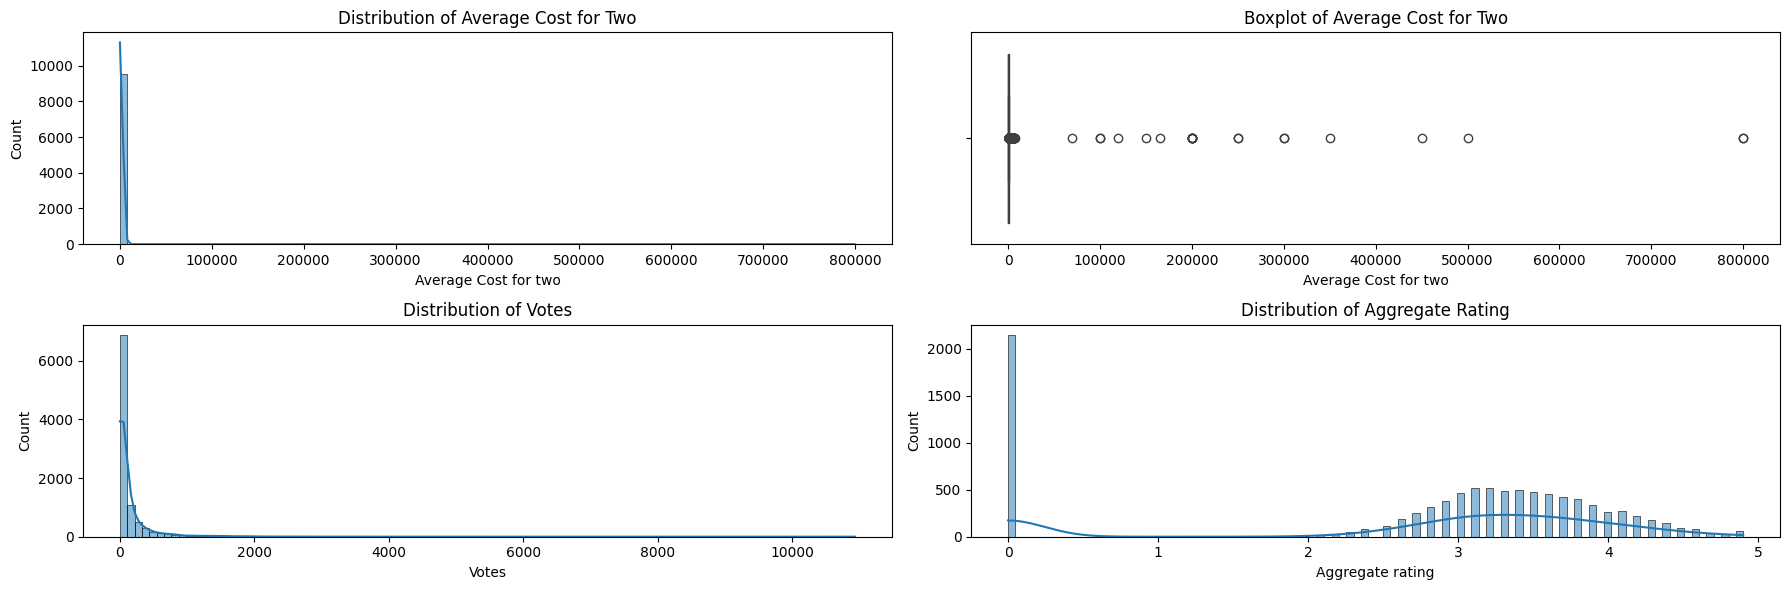

In [ ]:
plot_dist_hist(df_cuisines) # call the function

- __Average Cost for Two:__
    - Exhibited a long-tailed distribution with extreme outliers reaching up to ₹800,000. This justified the need for capping at the 99th percentile to reduce noise.

- __Votes:__
    - Displayed a high skew, with most restaurants clustered below 250 and rare cases exceeding 10,000 votes—these were clipped for stability.

- __Aggregate Rating:__
    - Had a smooth, near-normal distribution centered around ratings of 2.5–4.0, requiring minimal preprocessing.

- __Handling the Outliers__

In [ ]:
# Cap Cost
cost_cap = df_cuisines['Average Cost for two'].quantile(0.99)
df_cuisines['Average Cost for two'] = df_cuisines['Average Cost for two'].clip(upper=cost_cap)

# Cap Votes
votes_cap = df_cuisines['Votes'].quantile(0.99)
df_cuisines['Votes'] = df_cuisines['Votes'].clip(upper=votes_cap)

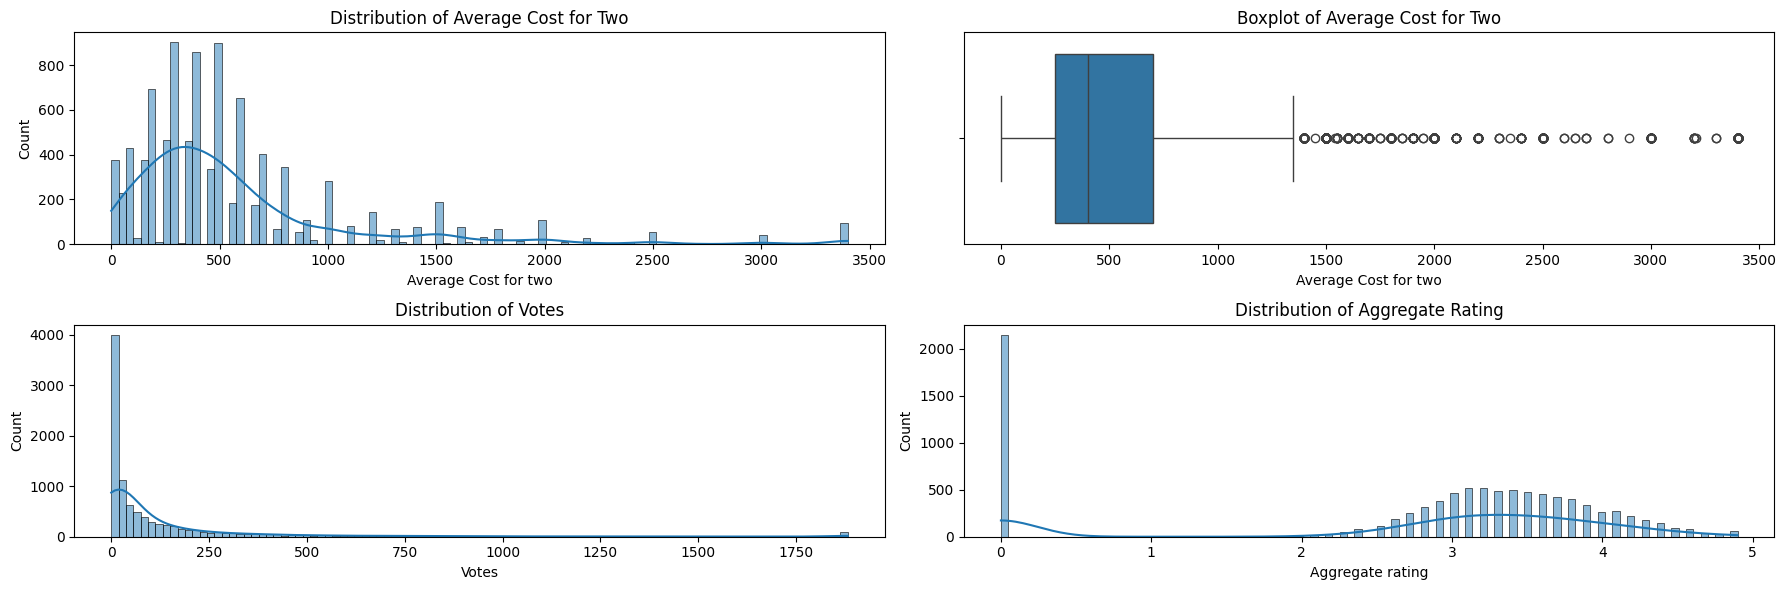

In [ ]:
plot_dist_hist(df_cuisines)

- Post-capping distributions of Cost and Votes appeared more balanced.

- Boxplot views confirmed that outlier clipping successfully minimized undue influence from rare, extreme values.

- __Remove Low-Variance Colum__

    - Based on .describe(), __Is delivering now__ has a mean of 0.003 = almost all zeros.
    - means this column adds no predictive signal and can be safely dropped:

In [ ]:
df_cuisines = df_cuisines.drop(columns=['Is delivering now'])

In [ ]:
df_cuisines.shape

(9551, 153)

### __Define Features and Target__

In [ ]:
X = df_cuisines.drop(columns=multi_label.classes_)

In [ ]:
X

,City,Average Cost for two,Currency,Has Table booking,Has Online delivery,Price range,Aggregate rating,Votes
0,73,1100,0,1,0,3,4.8,314.0
1,73,1200,0,1,0,3,4.5,591.0
2,75,3400,0,1,0,4,4.4,270.0
3,75,1500,0,0,0,4,4.9,365.0
4,75,1500,0,1,0,4,4.8,229.0
...,...,...,...,...,...,...,...,...
9546,140,80,11,0,0,3,4.1,788.0
9547,140,105,11,0,0,3,4.2,1034.0
9548,140,170,11,0,0,4,3.7,661.0
9549,140,120,11,0,0,4,4.0,901.0


In [ ]:
y = target_df

### __Train and Test Split__

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=19)

In [ ]:
X_train.shape, X_test.shape

((7640, 8), (1911, 8))

In [ ]:
forest = RandomForestClassifier(n_estimators=100, random_state=19)
model = MultiOutputClassifier(forest)
model.fit(X_train, y_train)


MultiOutputClassifier(estimator=RandomForestClassifier(random_state=19))

### __Evaluate Model Performance__

- __Make Prediction__

In [ ]:
# Predict cuisine labels for the test set using the trained model
y_pred = model.predict(X_test)

- __Top Performing Cuisines by Classification Metrics__

In [ ]:
# classification report as a dictionary for all cuisine labels
report = classification_report(y_test, y_pred, target_names=multi_label.classes_, output_dict=True,zero_division=0)
# Convert the report dictionary to a DataFrame for easier analysis
report_df = pd.DataFrame(report).transpose()
# Filter labels with support and sort by F1-score in descending order
filtered = report_df[report_df['support'] > 50].sort_values(by='f1-score', ascending=False)
# Display precision, recall, F1-score, and support for the top 20 cuisines
print(filtered[['precision', 'recall', 'f1-score', 'support']].head(20))

              precision    recall  f1-score  support
North Indian   0.583113  0.560914  0.571798    788.0
Chinese        0.469657  0.326606  0.385281    545.0
Fast Food      0.448780  0.229426  0.303630    401.0
micro avg      0.462394  0.221349  0.299383   3944.0
weighted avg   0.370033  0.221349  0.259622   3944.0
Pizza          0.588235  0.161290  0.253165     62.0
Continental    0.397260  0.182390  0.250000    159.0
samples avg    0.286377  0.212384  0.225675   3944.0
Street Food    0.369565  0.141667  0.204819    120.0
Italian        0.404255  0.125828  0.191919    151.0
Cafe           0.340426  0.115942  0.172973    138.0
American       0.388889  0.095890  0.153846     73.0
Mithai         0.260870  0.083333  0.126316     72.0
Mughlai        0.166667  0.057971  0.086022    207.0
South Indian   0.333333  0.048387  0.084507    124.0
Desserts       0.176471  0.043165  0.069364    139.0
Bakery         0.172414  0.028571  0.049020    175.0
macro avg      0.080529  0.029458  0.040096   

- __Classification Report Summary__

  - Due to the large number of labels (145 cuisines), we summarized the report as follows:
  - **Micro F1-score**: 0.30
  - **Macro F1-score**: 0.04 (impacted by rare labels)
  - **Top Predicted Cuisines**:
    - North Indian — F1: 0.57
    - Chinese — F1: 0.39
    - Fast Food — F1: 0.30
    - North Indian — support: 788 → This label appeared 788 times in y_test.
    - Pizza — support: 62 → Only 62 true samples with that label.
    - Rare cuisines with <10 samples were excluded from the summary to improve interpretability.

  **Labels like North Indian and Chinese performed well because there were more examples of them. Labels like Pizza, Continental, and Fast Food were accurate when predicted, but often missed real cases. Rare cuisines (like Mithai, Bakery, and South Indian) had low scores because there weren’t many examples. Overall, the scores are just okay, showing that it’s hard to predict many different cuisines when some are much less common than others.**

- __Visual Summary__

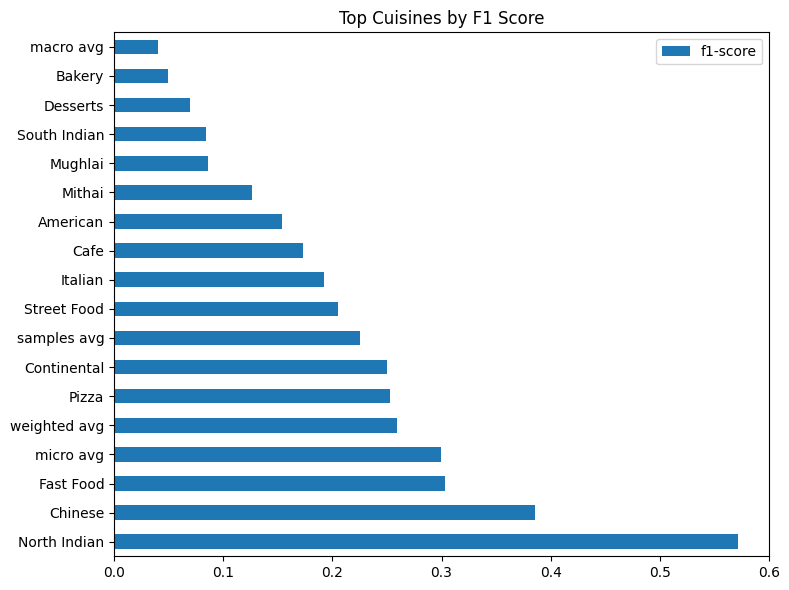

In [ ]:
filtered[['f1-score']].plot(kind='barh', figsize=(8,6), title="Top Cuisines by F1 Score")
plt.tight_layout()
plt.show()

- __Multi-Label Metrics__

In [ ]:
# Accuracy is for exact match (strict)
print("Subset Accuracy:", accuracy_score(y_test, y_pred))

# Fraction of wrongly predicted labels (lower = better)
print("Hamming Loss:", hamming_loss(y_test, y_pred))


Subset Accuracy: 0.06488749345892203
Hamming Loss: 0.014745845287717208


- __Subset Accuracy__ is ~6.5%, meaning the model predicted all correct cuisine labels for about 6.5% of restaurants.
- __Hamming Loss__ is ~1.47%, indicating a low rate of incorrect label assignments across all cuisines—overall, predictions are pretty reliable.

- ### __Feature Importance__

To understand how each input feature contributed to predicting specific cuisines, we accessed the Random Forest model trained for the first cuisine label,

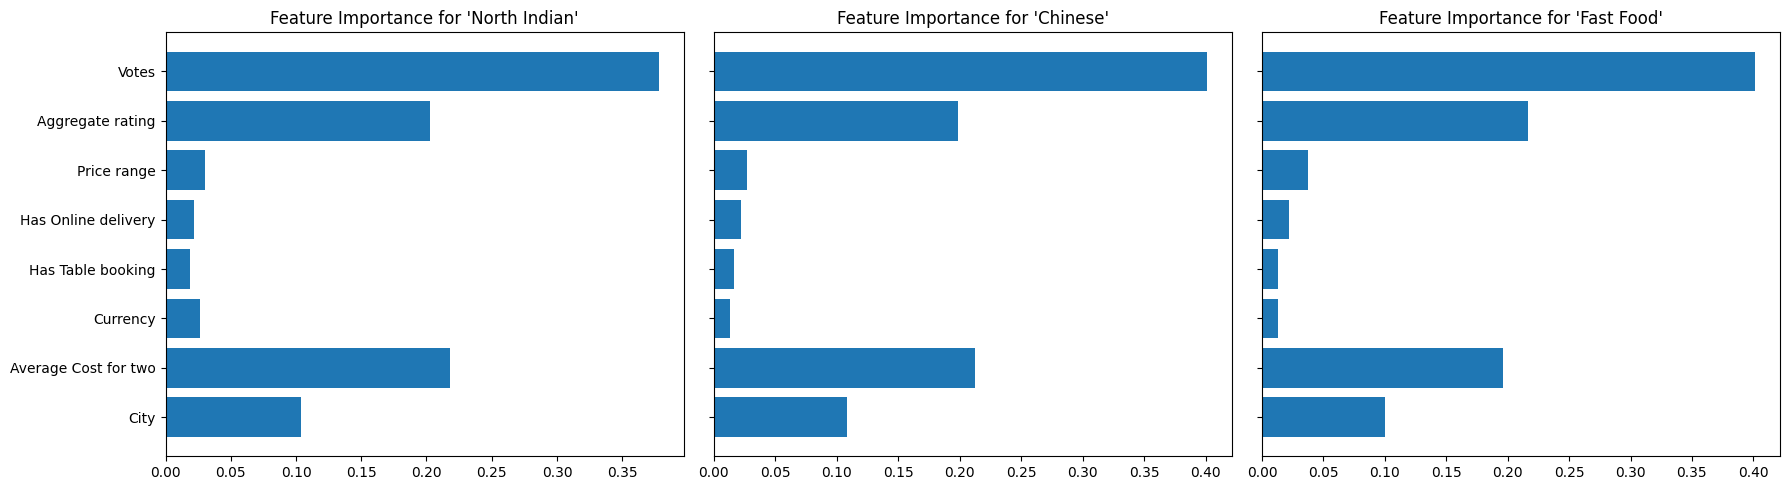

In [ ]:
# Create a list of index positions for selected cuisine labels -['North Indian', 'Chinese', 'Fast Food']
top_indices = [multi_label.classes_.tolist().index(cuisine) for cuisine in ['North Indian', 'Chinese', 'Fast Food']]
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True) # sharey - y-axis will be shared among all subplots.

for i, idx in enumerate(top_indices):

    # show Random Forest model trained for the 'North Indian', 'Chinese', 'Fast Food'
    rf_model = model.estimators_[idx]

    # Extract importance scores showing how much each feature influenced that label
    importances = rf_model.feature_importances_
    axes[i].barh(X.columns, importances)
    axes[i].set_title(f"Feature Importance for '{multi_label.classes_[idx]}'")

plt.tight_layout()
plt.show()


- __Votes__ and __Aggregate rating__ were consistently the most important features.
- Features like __City__, __Price range__, and __Average Cost for two__ also played helpful roles.
- Service-related features such as __Online delivery__ or __Table booking__ had low impact.

### __Model Evaluation Summary__

The multi-label Random Forest classifier was evaluated across 145 cuisine labels using a test set of 3,944 restaurants. Due to significant class imbalance, we focused on high-support cuisines for more meaningful insights.

#### Top Performing Cuisines

  | Cuisine      | Precision | Recall | F1-score | Support |
  |--------------|-----------|--------|----------|---------|
  | North Indian | 0.58      | 0.56   | 0.57     | 788     |
  | Chinese      | 0.47      | 0.33   | 0.39     | 545     |
  | Fast Food    | 0.45      | 0.23   | 0.30     | 401     |
  | Pizza        | 0.59      | 0.16   | 0.25     | 62      |
  | Continental  | 0.40      | 0.18   | 0.25     | 159     |


These cuisines were better predicted due to stronger representation and consistent feature patterns.

#### Overall Metrics

  | Metric          | Value   | Notes                                                  |
  |-----------------|---------|--------------------------------------------------------|
  | Micro F1        | 0.30    | Measures overall performance across all labels         |
  | Weighted F1     | 0.26    | Adjusted by how frequently each label appears          |
  | Samples Avg F1  | 0.23    | Average per-instance prediction accuracy               |
  | Macro F1        | 0.04    | Penalized by rare labels and uneven label distribution |
  | Hamming Loss    | 0.0147  | About 1.5% of label predictions were incorrect         |
  | Subset Accuracy | 0.0649  | Only 6.5% of predictions matched all true labels exactly |
      |

Rare labels (support < 10) had near-zero scores and contributed to low macro metrics. These were excluded from visualization for clarity.

- #### __Insights__

    - The model performs strongly on well-supported cuisines like North Indian and Chinese
    - Rare cuisines with low support tend to receive near-zero precision and recall
    - Subset accuracy is low, which is typical in multi-label settings with high class imbalance
    - Hamming Loss is low, confirming strong label-wise generalization

- #### __Challenge Identification__

    - While the model performs reliably on well-represented cuisines, several challenges were observed:
    - **Label imbalance**: Many cuisine classes have very few examples, leading to poor generalization.
    - **Sparse predictions**: Numerous labels received no predictions at all — triggering `UndefinedMetricWarning`.
    - **Low Macro F1-score (0.04)**: Confirms the model favors frequent labels and struggles with tail categories
- To enhance model performance future improvements could include:
    - Grouping ultra-rare cuisines under a single “Other” category
    - Applying threshold tuning or resampling techniques to balance predictions
    - Focusing modeling on high-support cuisines to boost precision and recall



**_These results provide a solid baseline. The model is deployment-ready and can be enhanced in future with rare label grouping and alternate classifiers._**


#### __Reflection & Submission Notes__

This notebook creates a model to predict restaurant cuisines using table data. It includes steps like cleaning the data, handling missing values, fixing outliers, and converting categories for the model. Cuisine labels are prepared so the model can predict several at once. A Random Forest model is used for prediction. The model works best for common cuisines like North Indian and Chinese. Performance is measured using F1 scores, Hamming Loss, and Subset Accuracy, giving a full picture of how well the model works.

- __Why Random Forest?__
    - Random Forest was selected for its ability to handle diverse feature types and high-dimensional label spaces without extensive parameter tuning.
- __Hyperparameter Consideration__
    - Uses default Random Forest parameters (n_estimators=100, random_state=19) to establish a reliable baseline. These settings already perform well across __high-support cuisine labels.__
    - Future iterations could improve performance by:
        - GridSearchCV for depth and split tuning
        - Resampling techniques for rare label enhancement
- __Feature scaling__ was skipped because Random Forests don’t need it the __size of the features(insensitive to feature magnitude)__ does not affect how they work.
    - adding scaling here wouldn't improve results


- #### __Save the Model__

In [ ]:
import pickle

# Save model
with open('cuisine_rf_model.pkl', 'wb') as file:
    pickle.dump(model, file)

- The trained model has been saved as `cuisine_rf_model.pkl` for deployment and future use.
- Link for pickle file - https://drive.google.com/file/d/1fxd-1DBv5rszVk-BNuCBUAS53Z0o6eWw/view?usp=drive_link


